prepare Libraries

In [37]:
# !pip install arabert
# !pip install --upgrade camel-tools
# !pip install --upgrade emoji
# !camel_data -i light
# !pip install transformers
# !pip install sklearn_crfsuite
# !pip install emoji==1.4.2
# !pip install arabert
# !pip install --upgrade camel-tools
# !pip uninstall emoji
# !pip install emoji==1.7
# !pip install farasa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, ImageColorGenerator

from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.tokenizers.morphological import MorphologicalTokenizer
from camel_tools.disambig.mle import MLEDisambiguator
from sklearn.feature_extraction import DictVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn_crfsuite import CRF
from nltk.tag.hmm import HiddenMarkovModelTrainer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import get_file
import os
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from collections import Counter
from nltk import UnigramTagger, BigramTagger, TrigramTagger, DefaultTagger
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

punctuationPattern = r"([*|,\-#!<&>_+{:/$\\=()?؟.،'}%\";\[\]])"
# # Initialize disambiguators
mle_msa = MLEDisambiguator.pretrained('calima-msa-r13')
msa_bw_tokenizer = MorphologicalTokenizer(disambiguator=mle_msa, scheme='atbtok')


def tokenize(text):
	tokens = msa_bw_tokenizer.tokenize([token for sent in re.split(punctuationPattern, text.strip()) for token in sent.split()])
	for i, token in enumerate(tokens):
	  if token.startswith(('ب', 'ف', 'ل')):
	    subtokens = token.split('+_')
	    if len(subtokens) > 1:
	      tokens[i] = subtokens[0]
	      tokens.insert(i+1, subtokens[1])
	  elif token == 'من_+ما':
	    tokens[i] = 'مما'
	  else:
	    tokens[i] = re.sub(r'\+_|_\+', '', token)
	return tokens

# preprocessing Data

In [2]:
# Split the data into training and testing sets
train_data = pd.read_csv("train.csv")
X = train_data[['question1', 'question2']]
Y = train_data['label']
# X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
# train_df = pd.concat([X_train, y_train], axis=1)
# test_df = pd.concat([X_test, y_test], axis=1)

In [3]:
train_data.head()

,question1,question2,label
0,ما هي الطرق الصحيحة للاعتناء بالحامل؟,كيف اهتم بطفلي؟,0
1,ما هي وسائل الاتصالات الحديثة؟,ماذا نعني بوسائل الاتصال الحديثة؟,1
2,ما طريقة تحضير محشي الكوسا ؟,من طرق تحضير محشي الكوسا؟,1
3,ما طريقة تحضير حلى الطبقات؟,من طرق تحضير طبقات الكيك؟,0
4,من الآيات القرآنية عن الراعي والرعية ؟,ما هو تعريف الراعي والرعية ؟,0


In [4]:
# number of question in csv
All_Question = pd.read_csv("train.csv")
print(All_Question.shape[0])

11997


In [5]:
train_data.head(30)

,question1,question2,label
0,ما هي الطرق الصحيحة للاعتناء بالحامل؟,كيف اهتم بطفلي؟,0
1,ما هي وسائل الاتصالات الحديثة؟,ماذا نعني بوسائل الاتصال الحديثة؟,1
2,ما طريقة تحضير محشي الكوسا ؟,من طرق تحضير محشي الكوسا؟,1
3,ما طريقة تحضير حلى الطبقات؟,من طرق تحضير طبقات الكيك؟,0
4,من الآيات القرآنية عن الراعي والرعية ؟,ما هو تعريف الراعي والرعية ؟,0
5,أين تقع قارة أوروبا؟,ما هو موقع اليمن؟,0
6,في أي عام ولد توفيق الحكيم؟,أين ولد توفيق الحكيم؟,0
7,ما هي قصيدة بائع الموت؟,ما هي أبيات قصيدة بائع الموت؟,1
8,ما طريقة تحضير االمهلبيّة بجوز الهند؟,كيف احضر المهلبيّة بجوز الهند؟,1
9,ما طريقة تحضير الكيك المحشي بالكريمة ؟,من طرق تحضير الكريمة؟,0


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11997 entries, 0 to 11996
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   question1  11997 non-null  object
 1   question2  11997 non-null  object
 2   label      11997 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 281.3+ KB


In [7]:
# remove duplicate & empty row
train_df = train_data.dropna().drop_duplicates()

In [8]:
# print the number row duplicate
train_df.duplicated().sum()

0

In [9]:
# Distribution of duplicate and non-duplicate questions
train_df['label'].value_counts()

0    6600
1    5397
Name: label, dtype: int64

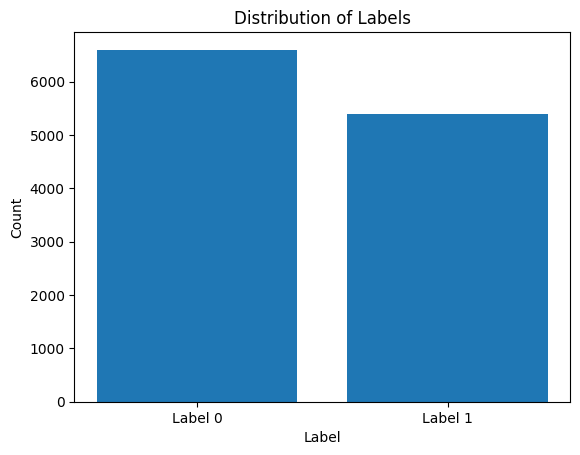

In [10]:
label_counts = train_df['label'].value_counts()
label_0_count = label_counts.get(0, 0)
label_1_count = label_counts.get(1, 0)

plt.bar(['Label 0', 'Label 1'], [label_0_count, label_1_count])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()


2.1 Text Cleaning

In [11]:
# Done
# 1 Remove Punctuation

def remove_punctuation(text):
    punctuation_pattern = r'[^\w\s\#]'
    result = re.sub(punctuation_pattern, '', text)
    return result

print("Cleaned Qestion1:")
for text in train_df['question1'].head(5):
    cleaned_text = remove_punctuation(text)
    print(cleaned_text)

print("Cleaned Question2:")
for text in train_df['question2'].head(5):
    cleaned_text = remove_punctuation(text)
    print(cleaned_text)

Cleaned Qestion1:
ما هي الطرق الصحيحة للاعتناء بالحامل
ما هي وسائل الاتصالات الحديثة
ما طريقة تحضير محشي الكوسا 
ما طريقة تحضير حلى الطبقات
من الآيات  القرآنية عن الراعي والرعية 
Cleaned Question2:
كيف اهتم بطفلي
ماذا نعني بوسائل الاتصال الحديثة
من طرق تحضير محشي الكوسا
من طرق تحضير   طبقات الكيك
ما هو تعريف الراعي والرعية 


In [12]:
# 2 Remove Numbers
def remove_all_numbers(text):
    number_pattern = r'\d+|[٠١٢٣٤٥٦٧٨٩]+'
    return re.sub(number_pattern, '', text)

print("questions1 with Numbers Removed:")
for text in train_df['question1'].head(3):
    cleaned_text = remove_all_numbers(text)
    print(cleaned_text)

print("Questions2 with Numbers Removed:")
for text in train_df['question2'].head(3):
    cleaned_text = remove_all_numbers(text)
    print(cleaned_text)

questions1 with Numbers Removed:
ما هي الطرق الصحيحة للاعتناء بالحامل؟
ما هي وسائل الاتصالات الحديثة؟
ما طريقة تحضير محشي الكوسا ؟
Questions2 with Numbers Removed:
كيف اهتم بطفلي؟
ماذا نعني بوسائل الاتصال الحديثة؟
من طرق تحضير محشي الكوسا؟


In [13]:
# 3 delete evrything not Arabic

def keep_arabic_numbers_punctuation(text):
    non_arabic_pattern = r'[^\u0600-\u06FF0-9\s\n.,;!?()،:؛؟"\':-]'
    result = re.sub(non_arabic_pattern, '', text)
    return result

print("Cleaned Qestion1:")
for text in train_df['question1'].head(5):
    cleaned_text = keep_arabic_numbers_punctuation(text)
    print(cleaned_text)

print("Cleaned Qestion2")
for text in train_df['question2'].head(5):
    cleaned_text = keep_arabic_numbers_punctuation(text)
    print(cleaned_text)

Cleaned Qestion1:
ما هي الطرق الصحيحة للاعتناء بالحامل؟
ما هي وسائل الاتصالات الحديثة؟
ما طريقة تحضير محشي الكوسا ؟
ما طريقة تحضير حلى الطبقات؟
من الآيات  القرآنية عن الراعي والرعية ؟
Cleaned Qestion2
كيف اهتم بطفلي؟
ماذا نعني بوسائل الاتصال الحديثة؟
من طرق تحضير محشي الكوسا؟
من طرق تحضير   طبقات الكيك؟
ما هو تعريف الراعي والرعية ؟


In [14]:
# 4 delete Duplicate Character
def remove_duplicated_letters(text):
    duplicate_pattern = r'(.)\1{2,}'
    return re.sub(duplicate_pattern, r'\1\1', text)

print("Cleaned question 1 :")
for text in train_df['question1'].head(5):
    cleaned_text = remove_duplicated_letters(text)
    print(cleaned_text)

print("Cleaned question 2 :")
for text in train_df['question2'].head(5):
    cleaned_text = remove_duplicated_letters(text)
    print(cleaned_text)

Cleaned question 1 :
ما هي الطرق الصحيحة للاعتناء بالحامل؟
ما هي وسائل الاتصالات الحديثة؟
ما طريقة تحضير محشي الكوسا ؟
ما طريقة تحضير حلى الطبقات؟
من الآيات  القرآنية عن الراعي والرعية ؟
Cleaned question 2 :
كيف اهتم بطفلي؟
ماذا نعني بوسائل الاتصال الحديثة؟
من طرق تحضير محشي الكوسا؟
من طرق تحضير  طبقات الكيك؟
ما هو تعريف الراعي والرعية ؟


In [15]:
# 5 remove duplicate spaces
def remove_duplicate_spaces(text):
    space_pattern = r'\s+'
    return re.sub(space_pattern, ' ', text)

print("Texts with Duplicate Spaces Removed:")
for text in train_df['question1'].head(5):
    cleaned_text = remove_duplicate_spaces(text)
    print(cleaned_text)

for text in train_df['question2'].head(5):
    cleaned_text = remove_duplicate_spaces(text)
    print(cleaned_text)

Texts with Duplicate Spaces Removed:
ما هي الطرق الصحيحة للاعتناء بالحامل؟
ما هي وسائل الاتصالات الحديثة؟
ما طريقة تحضير محشي الكوسا ؟
ما طريقة تحضير حلى الطبقات؟
من الآيات القرآنية عن الراعي والرعية ؟
كيف اهتم بطفلي؟
ماذا نعني بوسائل الاتصال الحديثة؟
من طرق تحضير محشي الكوسا؟
من طرق تحضير طبقات الكيك؟
ما هو تعريف الراعي والرعية ؟


In [16]:
#nltk.download('stopwords')
#nltk.download('punkt')

من الممكن ان لا احتاج إزالة stopwords لان اريد معرفة ماهية السؤال

In [17]:
# 6 delete StopWords
nltk.download('stopwords')
arabic_stopwords = set(stopwords.words('arabic'))
print(arabic_stopwords)

def remove_stop_words(text, stop_words):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

for text in train_df['question1'].head(5):
    cleaned_text = remove_stop_words(text, arabic_stopwords)
    print(cleaned_text)

for text in train_df['question2'].head(5):
    cleaned_text = remove_stop_words(text, arabic_stopwords)
    print(cleaned_text)

{'وإن', 'ما برح', 'آمينَ', 'ضاد', 'شَتَّانَ', 'أي', 'هَاتِه', 'لدى', 'هَاتَيْنِ', 'مع', 'انقلب', 'مما', 'ؤ', 'خ', 'أمد', 'ثمنمئة', 'حاشا', 'لسنا', 'لكيلا', 'مايو', 'كاد', 'خمسمائة', 'لمّا', 'لاسيما', 'ثمّة', 'ورد', 'كى', 'ما أفعله', 'تاء', 'ذانك', 'ث', 'كليهما', 'بؤسا', 'حادي', 'يونيو', 'وجد', 'أما', 'الألى', 'تارة', 'لي', 'ذا', 'أنّى', 'صار', 'أ', 'هَاتِي', 'ثلاثمائة', 'فيما', 'رويدك', 'إياهم', 'هلا', 'تسعة', 'بَلْهَ', 'لما', 'أخبر', 'ج', 'أل', 'سرا', 'حبذا', 'أنبأ', 'كليكما', 'ذهب', 'إذ', 'خاصة', 'ليسا', 'خمسمئة', 'أوشك', 'يمين', 'مكانكما', 'ما', 'ارتدّ', 'إياكن', 'تسعمئة', 'بعدا', 'حمو', 'صبرا', 'درهم', 'سوف', 'عشرين', 'ولكن', 'والذي', 'حتى', 'ليست', 'ثلاثين', 'إما', 'ثامن', 'أيار', 'إياهما', 'إذن', 'أهلا', 'شرع', 'فوق', 'كن', 'هاتي', 'خبَّر', 'آي', 'بكن', 'تعسا', 'تسعمائة', 'ليت', 'راء', 'وإذ', 'مائة', 'كلتا', 'استحال', 'أمسى', 'مذ', 'نعم', 'أولالك', 'لولا', 'خامس', 'لم', 'غين', 'أُفٍّ', 'ذو', 'ألفى', 'ض', 'لسن', 'كي', 'سرعان', 'وما', 'خميس', 'ذات', 'ة', 'تينك', 'هَذانِ', 'بلى', 'ك

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
# 7 Standardization of writing " ا "
def standardize_arabic_alef(text):
    return text.replace('آ', 'ا').replace('إ', 'ا').replace('آ', 'ا').replace('ة', 'ه').replace('ى', 'ي')

In [19]:
# 8
def standardize_arabic_haa(text):
    return text.replace('ة', 'ه')

In [20]:
#9
def standardize_arabic_yaa(text):
    return text.replace('ى', 'ي')

In [21]:
# 7 stemming
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("arabic")

In [22]:
#nltk.download('isri')

In [23]:
def normalize_arabic_word(input_string):
    words = input_string.split()
    processed_words = [normalize_arabic_one_word(word) for word in words]
    processed_string = ' '.join(processed_words)
    return processed_string

def normalize_arabic_one_word(word):
    stemmed_word = stemmer.stem(word)
    return stemmed_word

original_word = "فسيكفيكهم علاج الطبيب"

original_word = normalize_arabic_word(original_word)

print(original_word)


سيكف علاج طبيب


In [24]:
#إزالة كل الروابط
def replace_URL_with_symbol(text):
    url_pattern = r'https?://\S+|www\.\S+|/\S+-\S+/|\S+-\S+-\S+'
    return re.sub(url_pattern, "رابط", text)

In [25]:
##
def cleaned_Data(text) :
    text = remove_punctuation(text)
    text = remove_all_numbers(text)
    text = keep_arabic_numbers_punctuation(text)
    text = remove_duplicated_letters(text)
    text = remove_duplicate_spaces(text)
    text = standardize_arabic_alef(text)
    text = normalize_arabic_word(text)
    text = remove_stop_words(text, arabic_stopwords)
    text = standardize_arabic_haa(text)
    text = standardize_arabic_yaa(text)
    text = replace_URL_with_symbol(text)

    return text

In [26]:
for text in train_df['question1'].head(5):
    cleaned_text = cleaned_Data(text)
    print(cleaned_text)

print("__________________________________________________________________________\n")

for text in train_df['question2'].head(5):
    cleaned_text = cleaned_Data(text)
    print(cleaned_text)

طرق صحيحه اعتناء حامل
سايل اتصال حديثه
طريق تحضير محش الكو
طريق تحضير حل طبق
الا قرانيه راع والرع
__________________________________________________________________________

اهتم طفل
ماذ نعن وسايل اتصال حديثه
طرق تحضير محش الكو
طرق تحضير طبق كيك
تعريف راع والرع


In [27]:
######  apply the previous processes to the Train data
# من الممكن اعمل عمود جديد او عدل القديم

train_df["question1_clean"] = train_df["question1"].apply(lambda x: cleaned_Data(x))
train_df["question2_clean"] = train_df["question2"].apply(lambda x: cleaned_Data(x))

train_df.head(10)

,question1,question2,label,question1_clean,question2_clean
0,ما هي الطرق الصحيحة للاعتناء بالحامل؟,كيف اهتم بطفلي؟,0,طرق صحيحه اعتناء حامل,اهتم طفل
1,ما هي وسائل الاتصالات الحديثة؟,ماذا نعني بوسائل الاتصال الحديثة؟,1,سايل اتصال حديثه,ماذ نعن وسايل اتصال حديثه
2,ما طريقة تحضير محشي الكوسا ؟,من طرق تحضير محشي الكوسا؟,1,طريق تحضير محش الكو,طرق تحضير محش الكو
3,ما طريقة تحضير حلى الطبقات؟,من طرق تحضير طبقات الكيك؟,0,طريق تحضير حل طبق,طرق تحضير طبق كيك
4,من الآيات القرآنية عن الراعي والرعية ؟,ما هو تعريف الراعي والرعية ؟,0,الا قرانيه راع والرع,تعريف راع والرع
5,أين تقع قارة أوروبا؟,ما هو موقع اليمن؟,0,اين تقع قار اوروب,موقع يمن
6,في أي عام ولد توفيق الحكيم؟,أين ولد توفيق الحكيم؟,0,عام ولد توفيق حكيم,اين ولد توفيق حكيم
7,ما هي قصيدة بائع الموت؟,ما هي أبيات قصيدة بائع الموت؟,1,قصيد ايع الم,اب قصيد ايع الم
8,ما طريقة تحضير االمهلبيّة بجوز الهند؟,كيف احضر المهلبيّة بجوز الهند؟,1,طريق تحضير االمهلب جوز هند,احضر مهلبيه جوز هند
9,ما طريقة تحضير الكيك المحشي بالكريمة ؟,من طرق تحضير الكريمة؟,0,طريق تحضير كيك محش ريمه,طرق تحضير كريمه


In [29]:
#tokeniziton
train_df['tokenized_question1'] = train_df['question1_clean'].apply(lambda x: tokenize(str(x)))
train_df['tokenized_question2'] = train_df['question2_clean'].apply(lambda x: tokenize(str(x)))

In [30]:
train_df.head(30)

,question1,question2,label,question1_clean,question2_clean,tokenized_question1,tokenized_question2
0,ما هي الطرق الصحيحة للاعتناء بالحامل؟,كيف اهتم بطفلي؟,0,طرق صحيحه اعتناء حامل,اهتم طفل,"[طرق, صحيحه, اعتناء, حامل]","[اهتم, طفل]"
1,ما هي وسائل الاتصالات الحديثة؟,ماذا نعني بوسائل الاتصال الحديثة؟,1,سايل اتصال حديثه,ماذ نعن وسايل اتصال حديثه,"[سايل, اتصال, حديثه]","[ماذ, نعن, وسايل, اتصال, حديثه]"
2,ما طريقة تحضير محشي الكوسا ؟,من طرق تحضير محشي الكوسا؟,1,طريق تحضير محش الكو,طرق تحضير محش الكو,"[طريق, تحضير, محش, الكو]","[طرق, تحضير, محش, الكو]"
3,ما طريقة تحضير حلى الطبقات؟,من طرق تحضير طبقات الكيك؟,0,طريق تحضير حل طبق,طرق تحضير طبق كيك,"[طريق, تحضير, حل, طبق]","[طرق, تحضير, طبق, كيك]"
4,من الآيات القرآنية عن الراعي والرعية ؟,ما هو تعريف الراعي والرعية ؟,0,الا قرانيه راع والرع,تعريف راع والرع,"[إلا, قرآنيه, راع, والرع]","[تعريف, راع, والرع]"
5,أين تقع قارة أوروبا؟,ما هو موقع اليمن؟,0,اين تقع قار اوروب,موقع يمن,"[أين, تقع, قار, اوروب]","[موقع, يمن]"
6,في أي عام ولد توفيق الحكيم؟,أين ولد توفيق الحكيم؟,0,عام ولد توفيق حكيم,اين ولد توفيق حكيم,"[عام, ولد, توفيق, حكيم]","[أين, ولد, توفيق, حكيم]"
7,ما هي قصيدة بائع الموت؟,ما هي أبيات قصيدة بائع الموت؟,1,قصيد ايع الم,اب قصيد ايع الم,"[قصيد, ايع, ألم]","[آب, قصيد, ايع, ألم]"
8,ما طريقة تحضير االمهلبيّة بجوز الهند؟,كيف احضر المهلبيّة بجوز الهند؟,1,طريق تحضير االمهلب جوز هند,احضر مهلبيه جوز هند,"[طريق, تحضير, االمهلب, جوز, هند]","[أحضر, مهلبية, جوز, هند]"
9,ما طريقة تحضير الكيك المحشي بالكريمة ؟,من طرق تحضير الكريمة؟,0,طريق تحضير كيك محش ريمه,طرق تحضير كريمه,"[طريق, تحضير, كيك, محش, ريمه]","[طرق, تحضير, كريمه]"


TF-IDF

In [33]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# i use coustom tokenize
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(train_df, Y, test_size=0.2, random_state=42)

# Combine the tokenized columns into a single column for each row
X_train['combined_tokens'] = X_train.apply(lambda row: ' '.join(row['tokenized_question1'] + row['tokenized_question2']), axis=1)
X_test['combined_tokens'] = X_test.apply(lambda row: ' '.join(row['tokenized_question1'] + row['tokenized_question2']), axis=1)

# Create a pipeline with CountVectorizer, TfidfTransformer, and a classifier (e.g., Logistic Regression)
pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('tfidf_transformer', TfidfTransformer()),
    ('classifier', LogisticRegression())
])

# Train the model
pipeline.fit(X_train['combined_tokens'], y_train)

# Predictions
y_pred = pipeline.predict(X_test['combined_tokens'])

# Evaluate on the test set
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy}")
#Test Accuracy: 0.5729166666666666

Test Accuracy: 0.5729166666666666


RandomForestClassifier ML desicioun tree


In [34]:
from sklearn.ensemble import RandomForestClassifier
from farasa.pos import FarasaPOSTagger
from farasa.segmenter import FarasaSegmenter

# Combine the tokenized questions into a single list of strings
train_df['combined_tokenized_ML'] = train_df['tokenized_question1'] + train_df['tokenized_question2']
corpus = [' '.join(tokens) for tokens in train_df['combined_tokenized_ML']]

# Remove diacritics using farasa
farasa_segmenter = FarasaSegmenter(interactive=True)
corpus = [farasa_segmenter.segment(text) for text in corpus]

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(corpus, Y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_tfidf, y_train)

# Predictions
y_pred = rf_classifier.predict(X_test_tfidf)

# Evaluate on the test set
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy}")

[2024-01-10 08:42:58,112 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


Test Accuracy: 0.7829166666666667


In [35]:
# Example pair of questions
question1 = "كيف يمكنني تحسين مهارات برمجتي؟"
question2 = "هل هناك طرق فعّالة لتحسين مهارات البرمجة؟"

# Tokenize and remove diacritics using farasa
farasa_segmenter = FarasaSegmenter(interactive=True)
tokenized_question1 = farasa_segmenter.segment(' '.join(tokenize(question1)))
tokenized_question2 = farasa_segmenter.segment(' '.join(tokenize(question2)))

# Combine tokenized questions into a single list of strings
combined_tokenized = [' '.join([tokenized_question1, tokenized_question2])]

# Remove diacritics using farasa
corpus = [farasa_segmenter.segment(text) for text in combined_tokenized]

# TF-IDF Vectorization
X_tfidf = vectorizer.transform(corpus)

# Make predictions
prediction = rf_classifier.predict(X_tfidf)

print(f"Predicted Label: {prediction[0]}")

[2024-01-10 08:43:31,972 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


Predicted Label: 1


Question Representation

In [ ]:
# Function to load GloVe embeddings
def load_glove_embeddings(embeddings_path, embedding_dim):
    embeddings_index = {}
    with open(embeddings_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Function to create the embedding matrix
def create_embedding_matrix(tokenizer, embeddings_index, embedding_dim):
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [ ]:
# Download GloVe embeddings (Note: You might need to change the version number depending on GloVe's latest version)
glove_url = 'https://nlp.stanford.edu/data/glove.6B.zip'
glove_path = get_file('glove.6B.zip', glove_url, extract=True, cache_subdir='/content')

# Load GloVe embeddings
glove_embeddings_index = load_glove_embeddings('/content/glove.6B.300d.txt', embedding_dim=300)

862182613/862182613 [==============================] - 159s 0us/step


In [39]:
!pip install fasttext
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.bin.gz
!gunzip cc.ar.300.bin.gz
# Download and load Word2Vec embeddings
# import gensim.downloader as api
# word2vec_model = api.load("word2vec-google-news-300")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199772 sha256=3cdb5cb987241eca6a6168f30ceae00d2a606d2dd803626cb8b0b228b9d278d9
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext
--2024-01-10 06:34:02--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.249.120.114, 13.249.120.30, 13.249.120.117, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.249.120.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4500982519 (4.2G) [application/octet-stream]
Saving to: ‘cc.ar.300.bin.gz’

cc.ar.300.bin.gz    100%[===================>]   4.19G  59.3MB/s    in 80s     

202

In [38]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(train_df, Y, test_size=0.2, random_state=42)
# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['tokenized_question1'] + X_train['tokenized_question2'])
max_sequence_length = max(len(seq) for seq in tokenizer.texts_to_sequences(X_train['tokenized_question1'] + X_train['tokenized_question2']))
X_train_seq1 = pad_sequences(tokenizer.texts_to_sequences(X_train['tokenized_question1']), maxlen=max_sequence_length)
X_train_seq2 = pad_sequences(tokenizer.texts_to_sequences(X_train['tokenized_question2']), maxlen=max_sequence_length)
X_test_seq1 = pad_sequences(tokenizer.texts_to_sequences(X_test['tokenized_question1']), maxlen=max_sequence_length)
X_test_seq2 = pad_sequences(tokenizer.texts_to_sequences(X_test['tokenized_question2']), maxlen=max_sequence_length)
# Create the embedding matrix
# embedding_matrix = create_embedding_matrix(tokenizer, glove_embeddings_index, embedding_dim=300)

# Create the embedding matrix using Word2Vec
# embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300))
# for word, i in tokenizer.word_index.items():
#     if word in word2vec_model:
#         embedding_matrix[i] = word2vec_model[word]


In [39]:
import fasttext
import numpy as np

# Load FastText Arabic embeddings
fasttext_model_path = 'cc.ar.300.bin'
fasttext_model = fasttext.load_model(fasttext_model_path)

# Function to create the embedding matrix
def create_embedding_matrix(tokenizer, embeddings_model, embedding_dim):
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_model.get_word_vector(word)
        embedding_matrix[i] = embedding_vector

    return embedding_matrix

# Use FastText embeddings
embedding_matrix = create_embedding_matrix(tokenizer, fasttext_model, embedding_dim=300)

In [40]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, concatenate, GlobalMaxPooling1D, GRU

# # Model architecture
# input1 = Input(shape=(max_sequence_length,))
# input2 = Input(shape=(max_sequence_length,))

# embedding_layer_1 = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=300, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False)
# embedding_layer_2 = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=300, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False)

# lstm_layer = Bidirectional(LSTM(50, dropout=0.2, recurrent_dropout=0.2))

# encoded1 = lstm_layer(embedding_layer_1(input1))
# encoded2 = lstm_layer(embedding_layer_2(input2))

# merged = concatenate([encoded1, encoded2])
# merged = BatchNormalization()(merged)  # Batch normalization
# merged = Dropout(0.2)(merged)  # Dropout for regularization

# output = Dense(1, activation='sigmoid')(merged)

# model = Model(inputs=[input1, input2], outputs=output)
# model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# # Train the model
# model.fit([X_train_seq1, X_train_seq2], y_train, epochs=5, batch_size=64, validation_split=0.2)

# # Evaluate on the test set
# test_loss, test_accuracy = model.evaluate([X_test_seq1, X_test_seq2], y_test)
# print(f"Test Accuracy: {test_accuracy}")
#2 70%
# Model architecture
# input1 = Input(shape=(max_sequence_length,))
# input2 = Input(shape=(max_sequence_length,))
# embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=300, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False)

# lstm_layer = LSTM(50)
# encoded1 = lstm_layer(embedding_layer(input1))
# encoded2 = lstm_layer(embedding_layer(input2))

# merged = concatenate([encoded1, encoded2])
# output = Dense(1, activation='sigmoid')(merged)

# model = Model(inputs=[input1, input2], outputs=output)
# model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# # Train the model
# model.fit([X_train_seq1, X_train_seq2], y_train, epochs=10, batch_size=64, validation_split=0.2)

# # Evaluate on the test set
# test_loss, test_accuracy = model.evaluate([X_test_seq1, X_test_seq2], y_test)
# print(f"Test Accuracy: {test_accuracy}")
#3 Test Accuracy: 0.7458333373069763
# Model architecture
# input1 = Input(shape=(max_sequence_length,))
# input2 = Input(shape=(max_sequence_length,))
# embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=300, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False)

# lstm_layer = Bidirectional(LSTM(100, return_sequences=True))
# pooling_layer = GlobalMaxPooling1D()
# dense_layer = Dense(100, activation='relu')

# encoded1 = dense_layer(pooling_layer(lstm_layer(embedding_layer(input1))))
# encoded2 = dense_layer(pooling_layer(lstm_layer(embedding_layer(input2))))

# merged = concatenate([encoded1, encoded2])
# output = Dense(1, activation='sigmoid')(merged)

# model = Model(inputs=[input1, input2], outputs=output)
# model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# # Train the model
# model.fit([X_train_seq1, X_train_seq2], y_train, epochs=10, batch_size=64, validation_split=0.2)

# # Evaluate on the test set
# test_loss, test_accuracy = model.evaluate([X_test_seq1, X_test_seq2], y_test)
# print(f"Test Accuracy: {test_accuracy}")
#4
# Model architecture with GRU layers Test Accuracy: 0.7562500238418579
input1 = Input(shape=(max_sequence_length,))
input2 = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=300, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False)

gru_layer = Bidirectional(GRU(100, return_sequences=True))
pooling_layer = GlobalMaxPooling1D()
dense_layer = Dense(100, activation='relu')

encoded1 = dense_layer(pooling_layer(gru_layer(embedding_layer(input1))))
encoded2 = dense_layer(pooling_layer(gru_layer(embedding_layer(input2))))

merged = concatenate([encoded1, encoded2])
output = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
model.fit([X_train_seq1, X_train_seq2], y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate([X_test_seq1, X_test_seq2], y_test)
print(f"Test Accuracy: {test_accuracy}")
#5 Test Accuracy: 0.7112500071525574
# Model architecture with stacked GRU layers and Dropout
# input1 = Input(shape=(max_sequence_length,))
# input2 = Input(shape=(max_sequence_length,))
# embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=300, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False)

# gru_layer1 = Bidirectional(GRU(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
# gru_layer2 = Bidirectional(GRU(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
# gru_layer3 = Bidirectional(GRU(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))

# pooling_layer = GlobalMaxPooling1D()
# dense_layer = Dense(100, activation='relu')
# dropout_layer = Dropout(0.5)

# encoded1 = dropout_layer(pooling_layer(gru_layer3(gru_layer2(gru_layer1(embedding_layer(input1))))))  # Stack GRU layers for question1
# encoded2 = dropout_layer(pooling_layer(gru_layer3(gru_layer2(gru_layer1(embedding_layer(input2))))))  # Stack GRU layers for question2

# merged = concatenate([encoded1, encoded2])
# output = Dense(1, activation='sigmoid')(merged)

# model = Model(inputs=[input1, input2], outputs=output)
# model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# # Train the model
# model.fit([X_train_seq1, X_train_seq2], y_train, epochs=10, batch_size=64, validation_split=0.2)

# # Evaluate on the test set
# test_loss, test_accuracy = model.evaluate([X_test_seq1, X_test_seq2], y_test)
# print(f"Test Accuracy: {test_accuracy}")

Epoch 1/10
120/120 [==============================] - 48s 325ms/step - loss: 0.6384 - accuracy: 0.6196 - val_loss: 0.5844 - val_accuracy: 0.6687
Epoch 2/10
120/120 [==============================] - 38s 321ms/step - loss: 0.5431 - accuracy: 0.7108 - val_loss: 0.5689 - val_accuracy: 0.6932
Epoch 3/10
120/120 [==============================] - 43s 356ms/step - loss: 0.4928 - accuracy: 0.7481 - val_loss: 0.5548 - val_accuracy: 0.7177
Epoch 4/10
120/120 [==============================] - 52s 439ms/step - loss: 0.4536 - accuracy: 0.7776 - val_loss: 0.5495 - val_accuracy: 0.7141
Epoch 5/10
120/120 [==============================] - 34s 280ms/step - loss: 0.4119 - accuracy: 0.8030 - val_loss: 0.5439 - val_accuracy: 0.7234
Epoch 6/10
120/120 [==============================] - 59s 491ms/step - loss: 0.3598 - accuracy: 0.8316 - val_loss: 0.5459 - val_accuracy: 0.7391
Epoch 7/10
120/120 [==============================] - 31s 257ms/step - loss: 0.3163 - accuracy: 0.8591 - val_loss: 0.5669 - val_ac

In [41]:
# punctuationPattern = r"([*|,\-#!<&>_+{:/$\\=()?؟.،'}%\";\[\]])"
# # # Initialize disambiguators
# mle_msa = MLEDisambiguator.pretrained('calima-msa-r13')
# msa_bw_tokenizer = MorphologicalTokenizer(disambiguator=mle_msa, scheme='atbtok')


def tokenizee(text):
	tokens = msa_bw_tokenizer.tokenize([token for sent in re.split(punctuationPattern, text.strip()) for token in sent.split()])
	for i, token in enumerate(tokens):
	  if token.startswith(('ب', 'ف', 'ل')):
	    subtokens = token.split('+_')
	    if len(subtokens) > 1:
	      tokens[i] = subtokens[0]
	      tokens.insert(i+1, subtokens[1])
	  elif token == 'من_+ما':
	    tokens[i] = 'مما'
	  else:
	    tokens[i] = re.sub(r'\+_|_\+', '', token)
	return tokens
# Example input sequences
example_question1 = "كيف احضر المهلبيّة بجوز الهند؟"
example_question2 = "ما طريقة تحضير االمهلبيّة بجوز الهند؟"
def preprocess_and_tokenize(example_question1, example_question2):
  # Preprocess the examples using your cleaning and tokenization functions
  cleaned_question1 = cleaned_Data(example_question1)
  cleaned_question2 = cleaned_Data(example_question2)

  # Tokenize and pad the input sequences
  tokenized_question1 = tokenizee(str(cleaned_question1))
  tokenized_question2 = tokenizee(str(cleaned_question2))

  # Convert tokenized sequences to sequences of word indices
  sequence_question1 = tokenizer.texts_to_sequences([tokenized_question1])
  sequence_question2 = tokenizer.texts_to_sequences([tokenized_question2])

  # Pad sequences
  padded_question1 = pad_sequences(sequence_question1, maxlen=max_sequence_length)
  padded_question2 = pad_sequences(sequence_question2, maxlen=max_sequence_length)
  return padded_question1 , padded_question2

padded_question1, padded_question2 = preprocess_and_tokenize(example_question1, example_question2)
# Make predictions using the trained model
prediction = model.predict([padded_question1, padded_question2])
print(prediction)

# Convert the prediction to a binary label (0 or 1)
binary_prediction = 1 if prediction[0][0] >= 0.5 else 0

print(f"Similarity Prediction: {binary_prediction}")

1/1 [==============================] - 2s 2s/step
[[0.5721292]]
Similarity Prediction: 1


resulting embeddings will have multiple dimensions for each word in a sentence.

In [42]:
!pip install flask
!pip install tensorflow

In [43]:
!pip install flask-ngrok
!pip install pyngrok
!pip install flask-cors

In [45]:
# Import necessary modules
from flask import Flask
from pyngrok import ngrok
from flask import Flask, request, jsonify
from flask_cors import CORS
from flask import Flask, make_response

NGROK_AUTH_TOKEN = '3j85ZUfXBbVWN3TqmVUPk_7ZTjswsVKakKH8gY642VD'
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

import threading

# Create a Flask app
app = Flask(__name__)
# Enable CORS for all routes
def preprocess_and_tokenize(example_question1, example_question2):
    # Preprocess the examples using your cleaning and tokenization functions
    cleaned_question1 = cleaned_Data(example_question1)
    cleaned_question2 = cleaned_Data(example_question2)

    # Tokenize and pad the input sequences
    tokenized_question1 = tokenizee(str(cleaned_question1))
    tokenized_question2 = tokenizee(str(cleaned_question2))

    # Convert tokenized sequences to sequences of word indices
    sequence_question1 = tokenizer.texts_to_sequences([tokenized_question1])
    sequence_question2 = tokenizer.texts_to_sequences([tokenized_question2])

    # Pad sequences
    padded_question1 = pad_sequences(sequence_question1, maxlen=max_sequence_length)
    padded_question2 = pad_sequences(sequence_question2, maxlen=max_sequence_length)
    return padded_question1 , padded_question2
CORS(app, resources={r"/api/*": {"origins": "*"}})

# Define a route
@app.route('/')
def hello():
    return "Hello, this is your Flask app running on Google Colab!"
@app.route('/predict', methods=['POST', 'OPTIONS'])
def predict():
    if request.method == 'OPTIONS':
        # Handle preflight request
        response = make_response()
        response.headers.add('Access-Control-Allow-Origin', '*')
        response.headers.add('Access-Control-Allow-Methods', 'POST, OPTIONS')
        response.headers.add('Access-Control-Allow-Headers', 'Content-Type')
        return response
    else:
          try:
              # Get input data from the request
              data = request.get_json()
              sequence1 = data['sequence1']
              sequence2 = data['sequence2']

              # Preprocess the input sequences
              input_seq1, input_seq2 = preprocess_and_tokenize(sequence1, sequence2)

              # Make predictions using the loaded model
              predictions = model.predict([input_seq1, input_seq2])
              print(predictions)
              # Convert the prediction to a binary label (0 or 1)
              # binary_prediction = 1 if prediction[0][0] >= 0.5 else 0
              # print(binary_prediction)
              # Return the predictions as JSON
              response = jsonify({'probability': float(predictions)})
              response.headers.add('Access-Control-Allow-Origin', '*')
              return response

          except Exception as e:
              return jsonify({'error': str(e)})

@app.route('/predict/ml', methods=['POST', 'OPTIONS'])
def predictML():
    if request.method == 'OPTIONS':
        # Handle preflight request
        response = make_response()
        response.headers.add('Access-Control-Allow-Origin', '*')
        response.headers.add('Access-Control-Allow-Methods', 'POST, OPTIONS')
        response.headers.add('Access-Control-Allow-Headers', 'Content-Type')
        return response
    else:
          try:
              # Get input data from the request
              data = request.get_json()
              sequence1 = data['sequence1']
              sequence2 = data['sequence2']

              # Tokenize and remove diacritics using farasa
              farasa_segmenter = FarasaSegmenter(interactive=True)
              tokenized_question1 = farasa_segmenter.segment(' '.join(tokenize(sequence1)))
              tokenized_question2 = farasa_segmenter.segment(' '.join(tokenize(sequence2)))

              # Combine tokenized questions into a single list of strings
              combined_tokenized = [' '.join([tokenized_question1, tokenized_question2])]

              # Remove diacritics using farasa
              corpus = [farasa_segmenter.segment(text) for text in combined_tokenized]

              # TF-IDF Vectorization
              X_tfidf = vectorizer.transform(corpus)

              # Make predictions
              prediction = rf_classifier.predict(X_tfidf)
              # Return the predictions as JSON
              print(prediction)
              response = jsonify({'probability': float(prediction[0])})
              response.headers.add('Access-Control-Allow-Origin', '*')
              return response

          except Exception as e:
              return jsonify({'error': str(e)})

# Function to run ngrok in the background
def run_ngrok():
    ngrok_tunnel = ngrok.connect(5000)
    print(' * Tunnel URL:', ngrok_tunnel.public_url)

# Start ngrok in a separate thread
ngrok_thread = threading.Thread(target=run_ngrok)
ngrok_thread.start()

# Run the Flask app with host='0.0.0.0' and port=5000
app.run(host='0.0.0.0', port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit


 * Tunnel URL: https://6335-35-229-93-101.ngrok-free.app


[2024-01-10 09:03:02,197 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.
INFO:werkzeug:127.0.0.1 - - [10/Jan/2024 09:03:13] "POST /predict/ml HTTP/1.1" 200 -


[0]


[2024-01-10 09:04:18,242 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.
INFO:werkzeug:127.0.0.1 - - [10/Jan/2024 09:04:23] "POST /predict/ml HTTP/1.1" 200 -


[1]
1/1 [==============================] - 0s 35ms/step


INFO:werkzeug:127.0.0.1 - - [10/Jan/2024 09:04:31] "POST /predict HTTP/1.1" 200 -


[[0.4710821]]
1/1 [==============================] - 0s 53ms/step


INFO:werkzeug:127.0.0.1 - - [10/Jan/2024 09:04:51] "POST /predict HTTP/1.1" 200 -


[[0.4710821]]
1/1 [==============================] - 0s 34ms/step


INFO:werkzeug:127.0.0.1 - - [10/Jan/2024 09:05:44] "POST /predict HTTP/1.1" 200 -


[[0.70009667]]


[2024-01-10 09:05:51,358 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.
INFO:werkzeug:127.0.0.1 - - [10/Jan/2024 09:05:58] "POST /predict/ml HTTP/1.1" 200 -


[1]


INFO:werkzeug:127.0.0.1 - - [10/Jan/2024 09:08:07] "OPTIONS /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 31ms/step


INFO:werkzeug:127.0.0.1 - - [10/Jan/2024 09:08:07] "POST /predict HTTP/1.1" 200 -


[[0.41527307]]


INFO:werkzeug:127.0.0.1 - - [10/Jan/2024 09:08:23] "OPTIONS /predict/ml HTTP/1.1" 200 -
[2024-01-10 09:08:23,864 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.
INFO:werkzeug:127.0.0.1 - - [10/Jan/2024 09:08:29] "POST /predict/ml HTTP/1.1" 200 -


[1]
